# Tool to adjust the product and maintenance events in CREAM

<p> This jupyter notebook was used to adjust the timestamps of maintenance and product events. The timestamps from the events were generated with a minute precision. For most applications more detailed timestamps are necessary, hence we adapted them by hand to allow for extensive evaluation of applications like condition monitoring. </p>
<div class="alert alert-info">
    <h3>Instructions for using the adjustment notebook</h3>
    <p> First do all the product events, then the maintenance events for a particular day. </p>
    <p> For each event, the event itself and a +/- 1 minute window of data is plotted. </p>
    <p> The event was generated by the coffee maker after the procedure was finshed, hence, it can be located in the 60 seconds before or after the recorded event. </p>
    <p> Label the event according to the closest match. </p>
    <p> For each event, denote the start and end of the event by clicking two times into the graphic. </p>
    <p> Then you can load the next product / maintenance event. </p>

## Imports

In [19]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import h5py
import pandas as pd
import os
import sys
from pathlib import Path
from datetime import datetime
from datetime import timedelta
import math
import pdb
import scipy
# Add project path to path for import
project_path = os.path.abspath("..")
if project_path not in sys.path:
    sys.path.append(project_path)

# Add module path to path for import
module_path = os.path.abspath("../data_utility/data_utility.py")
if module_path not in sys.path:
    sys.path.append(module_path)
    
from data_utility import CREAM_Day # class to work with a day of the CREAM Dataset


%matplotlib notebook
# Intentional replication is necessary
%matplotlib notebook
%load_ext autoreload
# Reload all modules every time before executing the Python code typed.
%autoreload 2 
# Import some graphical modules
from IPython.display import display, clear_output
from ipywidgets import Button, Layout, ButtonStyle, HBox, VBox, widgets, Output
from IPython.display import SVG, display, clear_output

import subprocess

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Global Functions

In [2]:
def plot_event_window(event_timestamp:pd.Timestamp, event_type:str, window_size:int, current_CREAM_day:CREAM_Day, concurrent_events_dict:dict):
    """
    
    Plots a window of window_size in each direction around the event_timestamp.
    The event is marked as a bold red line.
    The current signal of the coffee maker is plotted.
    The event type is the label the event gets.
    If a concurrent_events_dict is provided, with the keys being the name of the event list and the values being the event dataframes,
    all other events that happen within the window of interest are also plotted.
    Appliance events are bold orange lines.
    Other events are dashed red lines.
    
    """
    
    # Import and set globals necessary for the click functions
    
    global EVENT_TYPE
    global EVENT_TIMESTAMP
    global WINDOW_START_TS
    global EVENT_DICTIONARY

   
        
    # Clear figure in case of any old figures in memoty
    
    
    # Tackle border cases of the timestamp
    if event_timestamp - timedelta(seconds=window_size) < current_CREAM_day.minimum_request_timestamp: # in case we are at the beginning of the day
        duration_to_left = event_timestamp - current_CREAM_day.minimum_request_timestamp
        duration_to_left = duration_to_left.total_seconds() # amount of data that we load now to the left of the current timestmap
        duration_to_right = window_size #to the right we can load the full window 
        
    elif event_timestamp + timedelta(seconds=window_size) >  current_CREAM_day.maximum_request_timestamp: # in case we are at the end of the day
        duration_to_right = current_CREAM_day.maximum_request_timestamp - event_timestamp
        duration_to_right = duration_to_right.total_seconds() #amount of data that we load now to the right of the current timestamp
        duration_to_left = window_size #to the left we can load the full window
    
    else: # if we have anough datapoints to the left and to the right to load the full WINDOW_SIZE in each direction
        duration_to_left = window_size
        duration_to_right = window_size
    
    # Create the start- and end-timestamp and compute the overall duration of the window
    duration = duration_to_left + duration_to_right
    start_ts = event_timestamp - timedelta(seconds=duration_to_left)
    end_ts = event_timestamp + timedelta(seconds=duration_to_right)

    # Load the data
    voltage, current = current_CREAM_day.load_time_frame(start_datetime=start_ts, duration=duration) #and WINDOW_SIZE seconds after the event
    
    if len(current[0]) == 0: #Debug in case the data is empty
        pdb.set_trace()
    
    # Compute the index of the event, using the timestamp
    event_index = current_CREAM_day.get_index_from_timestamp(start_ts, event_timestamp)
          
    fig, ax = plt.subplots(1,1)   
    fig.canvas.mpl_connect('button_press_event', onclick) #append event to figure
    
    xticks = np.arange(len(current[0]))
    ax.plot(xticks, current[0], markersize=0.1) 
    
    ax.tick_params(axis='x', rotation=90) #rotate the xlabels
 
    if np.max(current[0]) < 1: #in case of noise, show an appropriate range
           ax.set_ylim([-6,6])
       
    # Plot the event line
    ax.axvline(event_index, color="red", linewidth=1.5, label=event_type)
    
    # Add other events that happend within the window
    if len(concurrent_events_dict) > 0:
        
        for event_list_name, concurrent_events_df in concurrent_events_dict.items():
            concurrent_events_df_roi = concurrent_events_df[(concurrent_events_df.Timestamp <= end_ts) & (concurrent_events_df.Timestamp >= start_ts)]
            
            if len(concurrent_events_df_roi) > 0:
                for i, row in concurrent_events_df_roi.iterrows():
                    if "appliance" in event_list_name:
                        color="orange"
                        label = ""
                    else: # in case of product or maintenance events
                        color="red"
                        if "product" in event_list_name:
                            label=row.Product
                        elif "maintenance" in event_list_name:
                            label=row.Activity
                        else:
                            label="Unknown"

                    i = current_CREAM_day.get_index_from_timestamp(start_ts, row.Timestamp)
                    ax.axvline(i, color=color, linestyle=":", label=label)
                    
    # Display if there are any already labeled events, starting after the first window
    
    if len(EVENT_DICTIONARY["Start_Timestamp"]) > 1:
        concurrent_events_df = pd.DataFrame(EVENT_DICTIONARY)

        # use mask here because of misaligned indices 
        mask = (concurrent_events_df.Start_Timestamp <= end_ts) & (concurrent_events_df.Start_Timestamp >= start_ts)
        concurrent_events_df_roi = concurrent_events_df.loc[mask.values]
        
        for i, row in concurrent_events_df_roi.iterrows():
            i = current_CREAM_day.get_index_from_timestamp(start_ts, row.Start_Timestamp)
            ax.axvline(i, color="green", linestyle=":", label="already labeled start" + str(i))
            
    fig.suptitle("Event type: " + event_type + "\n" + str(str(start_ts) + " - " + str(end_ts)))
    ax.legend(loc='upper right')
    
    EVENT_TYPE = label
    EVENT_TIMESTAMP = event_timestamp
    WINDOW_START_TS = start_ts
    return fig, ax

## Global Settings

##  Global Variables

In [3]:
EVENT_INDEX = 0
EVENT_TYPE = None
EVENT_TIMESTAMP = None
WINDOW_START_TS = None
EVENT_DICTIONARY = {
    "Start_Timestamp": [],
    "Automatic_Timestamp" : [],
    "Event_Type" : [],
    "End_Timestamp" : []
}

LABELED_TIMESTAMP = (None, None) #the last labeled start, end timestmap
WINDOW_SIZE = 60 #seconds, the window size in each direction around and event to be displayed

## Widget functions for the UI

In [25]:
def onclick(event):
    """
    Function to be executed in case of a click event at a figure.
    """
    global LABELED_TIMESTAMP # the tuple of the timestamps labeled (start, end)
    global EVENT_TYPE #type of the event of interest
    global EVENT_TIMESTAMP #timestamp of the event of interest that was autoamticcaly generated
    global WINDOW_START_TS #start timestamp of the window we are currently looking at
    global current_CREAM_day #object representing the current day in the CREAM dataset
    global FIG #global figure object
    global AX #global axis object
    global EVENT_DICTIONARY
    global current_CREAM_day
    
    if current_CREAM_day.get_timestamp_from_index(WINDOW_START_TS, math.floor(event.xdata)) > EVENT_TIMESTAMP:
        print("The red timestamp is generated after the event is completed! Hence, do not place the click after it!")
        return
        
        
    if LABELED_TIMESTAMP[0] is None:
        
        LABELED_TIMESTAMP = (math.floor(event.xdata), None)
        AX.axvline(LABELED_TIMESTAMP[0], color="yellow", linewidth=1.5)
        FIG.show()
    elif LABELED_TIMESTAMP[0] is not None and LABELED_TIMESTAMP[1] is None :
        
        if LABELED_TIMESTAMP[0] > event.xdata: #if the second click is before the first one
            print("Please place the second click after the first one!")
            return
    
        
        LABELED_TIMESTAMP = (LABELED_TIMESTAMP[0], math.floor(event.xdata))
        AX.axvline(LABELED_TIMESTAMP[1], color="yellow", linewidth=1.5)
        
        FIG.show()
    else:
        print("Already selected two borders")
        return
    

In [5]:
def on_remove_last_click(event):
    """
    Delete the last click
    """
    global FIG #global figure object
    global AX #global axis object
    global LABELED_TIMESTAMP # the tuple of the timestamps labeled (start, end)
    if LABELED_TIMESTAMP == (None, None):
        print("No click to be deleted!")
        return
    
    if LABELED_TIMESTAMP[1] is None: #if the second is None, then the first was the last click
        LABELED_TIMESTAMP = (None, None)
    
    elif None not in LABELED_TIMESTAMP: #both are not None, the the second gets deleeated
        LABELED_TIMESTAMP = (LABELED_TIMESTAMP[0], None)
        
    AX.lines[-1].remove()
    
    FIG.show()

In [6]:
def display_initial_event():
    
    global EVENT_LABELING_MODE #either product mode or maintenance mode
        
    global EVENT_INDEX # index of the last event loaded
    global maintenance_events #dataframe containing all the maintenance events
    global appliance_events #dataframe containing all the appliance events
    global current_CREAM_day #object representing the current day in the CREAM dataset
    global WINDOW_SIZE #window size used to display the data
    global LABELED_TIMESTAMP # the tuple of the timestamps labeled (start, end)
    global FIG #global figure object
    global AX #global axis object
    global OUTPUT #global output widget
    
  
    
    EVENT_INDEX = 0
    
    plt.clf()
    clear_output()
    print("The current Event Index is " + str(EVENT_INDEX))
    
     # Depending on the Mode, either use the product or maintenance events
    if "product" in EVENT_LABELING_MODE:
        
        if EVENT_INDEX > len(product_events)-1:
            print("THIS WAS THE LAST EVENT! YOU ARE DONE!")
            return 
        product_row = product_events.iloc[EVENT_INDEX]
        
     
        FIG, AX = plot_event_window(event_timestamp = product_row.Timestamp, 
            event_type = product_row.Product,
            window_size = WINDOW_SIZE,
            current_CREAM_day = current_CREAM_day,
            concurrent_events_dict = {
              "maintenance_events" : maintenance_events,
              "appliance_events" : appliance_events
            })
        
    elif "maintenance" in EVENT_LABELING_MODE:
        if EVENT_INDEX > len(maintenance_events)-1:
            print("THIS WAS THE LAST EVENT! YOU ARE DONE!")
            return 
        
        maintenance_row = maintenance_events.iloc[EVENT_INDEX]
        
        FIG, AX = plot_event_window(event_timestamp = maintenance_row.Timestamp, 
            event_type = maintenance_row.Product,
            window_size = WINDOW_SIZE,
            current_CREAM_day = current_CREAM_day,
            concurrent_events_dict = {
              "product_events" : product_events,
              "appliance_events" : appliance_events
            })
        
    else:
        raise ValueError("This event labeling mode is not available. Please select maintenance or product!")
    
    FIG.show()
    display(button_box)
    LABELED_TIMESTAMP = (None, None)

In [7]:
def on_next_clicked(event):
    
    global EVENT_LABELING_MODE #either product mode or maintenance mode
    
    global EVENT_INDEX # index of the last event loaded
    global maintenance_events #dataframe containing all the maintenance events
    global appliance_events #dataframe containing all the appliance events
    global current_CREAM_day #object representing the current day in the CREAM dataset
    global WINDOW_SIZE #window size used to display the data
    global LABELED_TIMESTAMP # the tuple of the timestamps labeled (start, end)
    global FIG #global figure object
    global AX #global axis object
    global OUTPUT #global output widget
    global LABEL_DESTINATION_PATH #location where the event labels will be stored, is user specified
    global EVENT_DICTIONARY #global event dictionary
    global EVENT_TYPE #type of the event of interest
    global EVENT_TIMESTAMP #timestamp of the event of interest that was autoamticcaly generated
    global WINDOW_START_TS #start timestamp of the window we are currently looking at
    global current_CREAM_day #object representing the current day in the CREAM dataset
    
    if None in LABELED_TIMESTAMP:
        print("Click another Time")
        return 
    
    # first add the last event to the labels and save it
    
    start_ts = current_CREAM_day.get_timestamp_from_index(WINDOW_START_TS, LABELED_TIMESTAMP[0] )
    test_start = current_CREAM_day.get_index_from_timestamp(WINDOW_START_TS, start_ts)        
    end_ts = current_CREAM_day.get_timestamp_from_index(WINDOW_START_TS, LABELED_TIMESTAMP[1] )
    EVENT_DICTIONARY["Start_Timestamp"].append(start_ts)
    EVENT_DICTIONARY["Event_Type"].append(EVENT_TYPE)
    EVENT_DICTIONARY["Automatic_Timestamp"].append(EVENT_TIMESTAMP)
    EVENT_DICTIONARY["End_Timestamp"].append(end_ts)
    save_labels(destination=LABEL_DESTINATION_PATH) #save it
        
    EVENT_INDEX += 1
    if EVENT_INDEX <= 0: #Must not be negative 
        print("This is the first event, you can not go further back in time!")
        return 
    
    
    plt.clf()
    clear_output()
    print("The current Event Index is " + str(EVENT_INDEX))
    
    # Depending on the Mode, either use the product or maintenance events
    if "product" in EVENT_LABELING_MODE:
        
        if EVENT_INDEX > len(product_events)-1:
            print("THIS WAS THE LAST EVENT! YOU ARE DONE!")
            return 
        product_row = product_events.iloc[EVENT_INDEX]
        
     
        FIG, AX = plot_event_window(event_timestamp = product_row.Timestamp, 
            event_type = product_row.Product,
            window_size = WINDOW_SIZE,
            current_CREAM_day = current_CREAM_day,
            concurrent_events_dict = {
              "maintenance_events" : maintenance_events,
              "appliance_events" : appliance_events
            })
        
    elif "maintenance" in EVENT_LABELING_MODE:
        if EVENT_INDEX > len(maintenance_events)-1:
            print("THIS WAS THE LAST EVENT! YOU ARE DONE!")
            return 
        
        maintenance_row = maintenance_events.iloc[EVENT_INDEX]
        
        FIG, AX = plot_event_window(event_timestamp = maintenance_row.Timestamp, 
            event_type = maintenance_row.Product,
            window_size = WINDOW_SIZE,
            current_CREAM_day = current_CREAM_day,
            concurrent_events_dict = {
              "product_events" : product_events,
              "appliance_events" : appliance_events
            })
        
    else:
        raise ValueError("This event labeling mode is not available. Please select maintenance or product!")
        
    FIG.show()
    display(button_box)
    LABELED_TIMESTAMP = (None, None)
    
    # save the last labeled event
    save_labels(destination=LABEL_DESTINATION_PATH)

In [8]:
def save_labels(destination: str):
    global EVENT_DICTIONARY
    events_df = pd.DataFrame(EVENT_DICTIONARY)
    filename = "labels" + ".csv"
    events_df.to_csv(os.path.join(destination, filename), index=False)


In [9]:
def on_delete_clicked(event):
    """
    Deletes the last click from every key in the event_dictionary and returns to the previous window
    """
    global EVENT_DICTIONARY
    global EVENT_INDEX
    global LABELED_TIMESTAMP
    global FIG
    global AX
    
    if EVENT_INDEX <= 0: #we arrived at the first event again
        print("This is the first event, you can not go further back in time!")
        return 
    
    for k, v in EVENT_DICTIONARY.items():
        EVENT_DICTIONARY[k] = v[:-1]
    
    EVENT_INDEX = EVENT_INDEX - 1
    
    LABELED_TIMESTAMP = (None, None)
    
    # Now display the last event
    plt.clf()
    clear_output()
    print("The current Event Index is " + str(EVENT_INDEX))
    
    # Depending on the Mode, either use the product or maintenance events
    if "product" in EVENT_LABELING_MODE:
        
        if EVENT_INDEX > len(product_events)-1:
            print("THIS WAS THE LAST EVENT! YOU ARE DONE!")
            return 
        product_row = product_events.iloc[EVENT_INDEX]
        
     
        FIG, AX = plot_event_window(event_timestamp = product_row.Timestamp, 
            event_type = product_row.Product,
            window_size = WINDOW_SIZE,
            current_CREAM_day = current_CREAM_day,
            concurrent_events_dict = {
              "maintenance_events" : maintenance_events,
              "appliance_events" : appliance_events
            })
        
    elif "maintenance" in EVENT_LABELING_MODE:
        if EVENT_INDEX > len(maintenance_events)-1:
            print("THIS WAS THE LAST EVENT! YOU ARE DONE!")
            return 
        
        maintenance_row = maintenance_events.iloc[EVENT_INDEX]
        
        FIG, AX = plot_event_window(event_timestamp = maintenance_row.Timestamp, 
            event_type = maintenance_row.Product,
            window_size = WINDOW_SIZE,
            current_CREAM_day = current_CREAM_day,
            concurrent_events_dict = {
              "product_events" : product_events,
              "appliance_events" : appliance_events
            })
        
    else:
        raise ValueError("This event labeling mode is not available. Please select maintenance or product!")
        
    FIG.show()
    display(button_box)
    
    return EVENT_DICTIONARY

# Only touch this area in the notebook to alter variables, like, the day of interest and the path to the day

<div class="alert alert-danger">
    <h3>//ToDo</h3>
    <p>Please specify whether you label maintenance our product events </p>
</div>

In [10]:
EVENT_LABELING_MODE = "product" #"product" or "maintenance"

<div class="alert alert-danger">
    <h3>//ToDo</h3>
    <p>Please specify the path to the main-folder of "CREAM". </p>
</div>

In [11]:
PATH_TO_DATA = os.path.abspath(os.path.join("..", "..", "Datasets", "CREAM", "CREAM_6400"))

<div class="alert alert-danger">
    <h3>//ToDo</h3>
    <p>Please specify the path to location where you want to store the labels. </p>
</div>

In [12]:
LABEL_DESTINATION_PATH = os.path.abspath(os.path.join("..", "..", "Datasets", "CREAM", "Labels"))

<div class="alert alert-danger">
    <h3>//ToDo</h3>
    <p>After you are done with a day, select the new day by altering the <b> CURRENT_DAY </b> variable and reset the notebook </p>
</div>

In [13]:
CURRENT_DAY = "2018-08-24"

# Here you can label the product events of this day

## Execute this cell to load the event files

In [14]:
#necessary for the plotting
# Load the events and already filter for the day of interest
# Load the maintenance and product events
day_path = os.path.join(PATH_TO_DATA, CURRENT_DAY)
current_CREAM_day = CREAM_Day(cream_day_location=day_path,use_buffer=True, buffer_size_files=2) 
maintenance_events = current_CREAM_day.load_maintenance_events(os.path.join(PATH_TO_DATA, "maintenance_events.csv"), filter_day=True)
product_events = current_CREAM_day.load_product_events(os.path.join(PATH_TO_DATA,"product_events.csv"), filter_day=True)
# Load the electrical appliance events
appliance_events = current_CREAM_day.load_event_labels(os.path.join(PATH_TO_DATA,"event_list.csv"), filter_day=True)

## Execute the cell below to get started with the labeling

<p> Place two clicks in the graph: One where the event starts, and one where it ends. They will appear in yellow </p>
<p> To ease labeling and to raise awareness for concurrent events the follwoing lines are displayed: </p>
    <p> Already labeled events (the start indices) are shown in yellow in the graph </p>
    <p> Appliance event labels are shown in dashed orange lines </p>
    <p> Any other producr or maintenance event is show with a dashed red line </p>
<p> If you want to delete the last click: Use the <b> "remove last click" </b> button (the middle, red one) </p>
<p> If you think you are done with this event, click the green <b> "next" </b> button to load the next event and save the preivous one </p>
<p> If you have selected <b> "next" </b> accidentially or still to remove the event borders you have labeled from the previous event,
select the other red button, the <b> "delete last entry" </b> one. </p>

<div class="alert alert-danger">
    <h4>Empty Figure or not in interactive mode</h4>
    <p>If the plot does not load or is not in the interactive mode, reexecute the cell or reexcute the import cell</p>
</div>

The current Event Index is 1


<IPython.core.display.Javascript object>


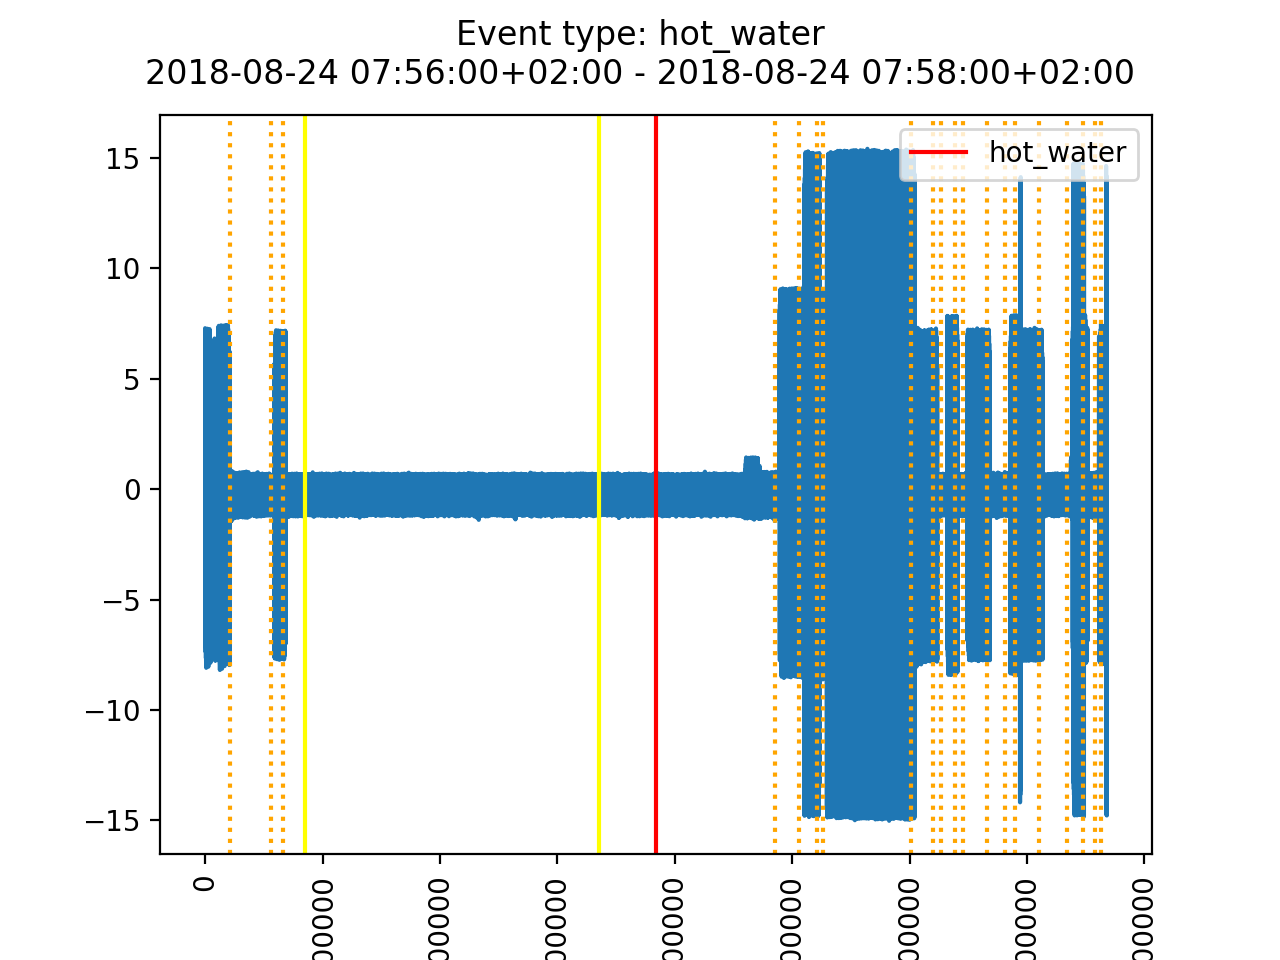

In [26]:
# Create and register Buttons
next_button =  Button(description="Next -> ",style=ButtonStyle(button_color='green'))
delete_button = Button(description=" <- Delete last entry",style=ButtonStyle(button_color='red'))
remove_last_click_button = Button(description="Remove last click",style=ButtonStyle(button_color='red'))
button_box = HBox([next_button, remove_last_click_button, delete_button])
next_button.on_click(on_next_clicked)
delete_button.on_click(on_delete_clicked)
remove_last_click_button.on_click(on_remove_last_click)

# Display first event
display_initial_event()

In [28]:
EVENT_DICTIONARY = {'Start_Timestamp': [],
 'Automatic_Timestamp': [],
 'Event_Type': [],
 'End_Timestamp': []}

In [29]:
# TODO irgendwas is nopt mit der click log für die timestampos

In [18]:
# At the end we need to check wether we have labeeld overlapping events!! manually correct them!